In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ShuffleSplit, cross_validate, cross_val_score,validation_curve

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn import tree





In [2]:
np.random.seed(306)

Let's use ShuffleSplit as cv with 10 splits and 20% examples set aside as test examples

In [3]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

Load the data set

In [4]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

# train --> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)


Model setup

In [5]:
dt_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                 ("dt_reg", DecisionTreeRegressor(max_depth=3, random_state=42))])

dt_reg_cv_results = cross_validate(dt_reg_pipeline,
                                   com_train_features,
                                   com_train_labels,
                                   cv=cv,
                                   scoring="neg_mean_absolute_error",
                                   return_train_score=True,
                                   return_estimator=True)

dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(f"Mean absolute error of decision tree regression model on the train set:\n"f"{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}")
print(f"Mean absolute arror of decision tree regression model on the test set:\n"f"{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f}")

Mean absolute error of decision tree regression model on the train set:
0.590 +/- 0.005
Mean absolute arror of decision tree regression model on the test set:
0.593 +/- 0.007


**Visualizing the tree**
1) As a tree diagram
2) As a text based diagram

In [6]:
# We have to call fit function on pipeline object before printing the tree

In [7]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

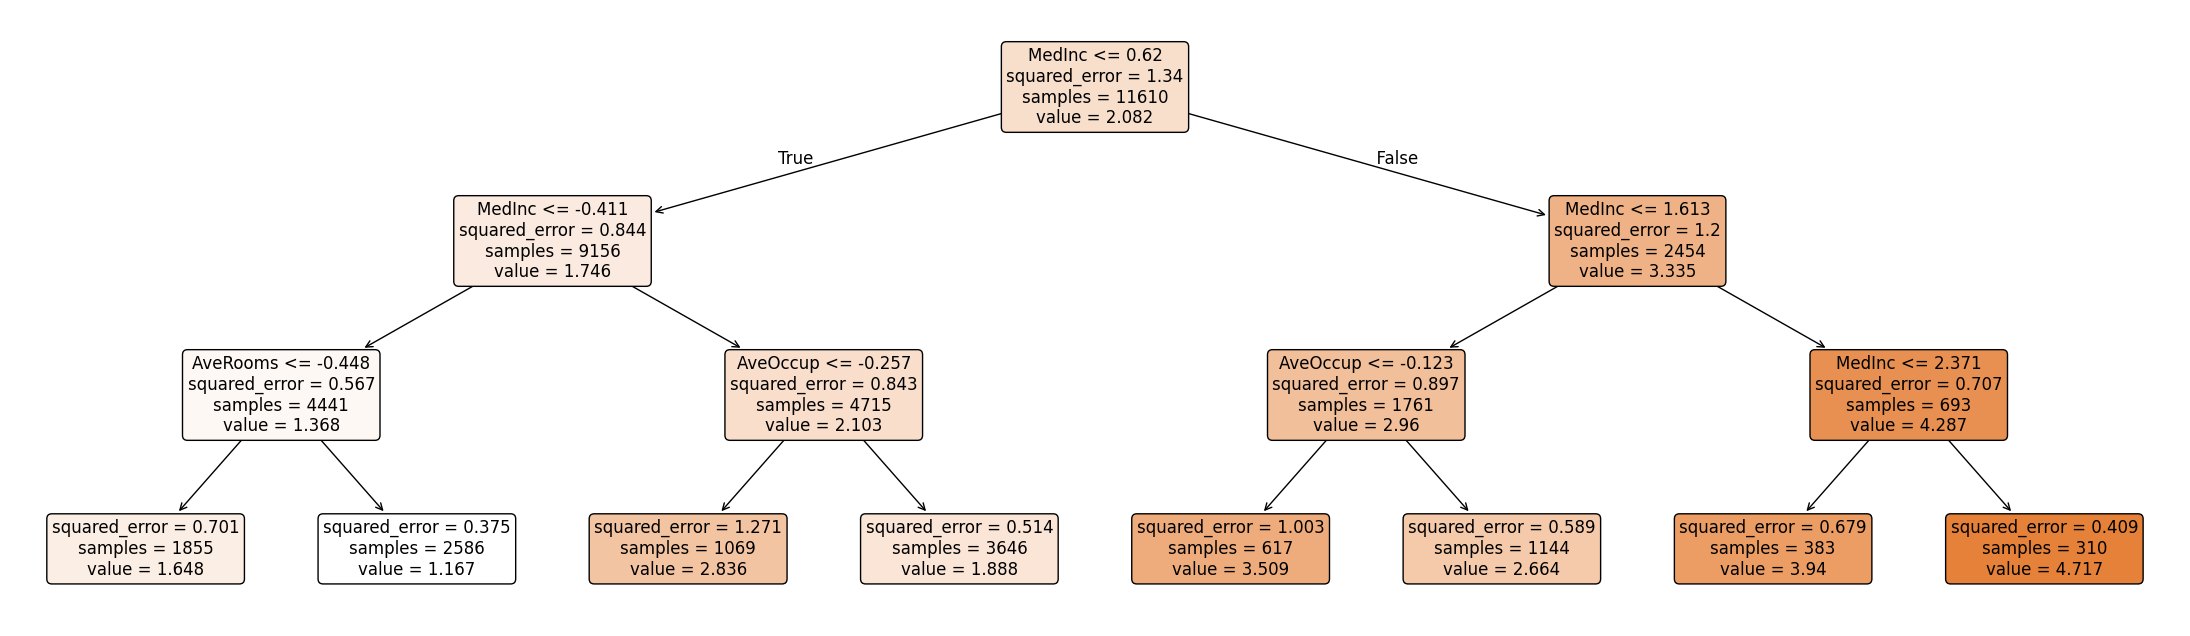

In [8]:
plt.figure(figsize=(28,8), facecolor="w")
#create the tree plot
a = tree.plot_tree(dt_reg_pipeline[-1],
                   #use the feature names stored
                   feature_names = features.columns,
                   rounded = True,
                   filled = True,
                   fontsize=12)
#show the plot
plt.show()

In [9]:
# export the decision rules
tree_rules = export_text(dt_reg_pipeline[-1])
#print the result
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



**Using the tree for prediction**

In [10]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

**Evaluating the tree**

In [11]:
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)
print("The model performance for testing set")
print("--------------------------------------")
print('MAE is ', mae)
print('MSE is ', mse)
print('R2 score is ',r2)

The model performance for testing set
--------------------------------------
MAE is  0.6005762942842664
MSE is  0.6417557936098145
R2 score is  0.5150037690483743


Improve the model by turning the hyperparameter

In [12]:
param_grid = {'dt_reg__max_depth': range(1, 20),
              'dt_reg__min_samples_split': range(2, 8)}

dt_grid_search = GridSearchCV(dt_reg_pipeline,
                              param_grid=param_grid,
                              n_jobs=2,
                              cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True)

dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [15]:
mmean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(f"Best Mean absolute error of decision tree regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of decision tree regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of decision tree regression model on the train set:
0.278 +/- 0.006
Mean absolute error of decision tree regression model on the test set:
0.428 +/- 0.012


In [16]:
print("Mean cross validated score of the best estimator is: ",-1*dt_grid_search.best_score_)

Mean cross validated score of the best estimator is:  0.4283313044233501


In [17]:
print("The best parameter value is:", dt_grid_search.best_params_)

The best parameter value is: {'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


Train the model with the best hyperparameter values

In [18]:
dt_reg_pipeline.set_params(
    dt_reg__max_depth = 11, dt_reg__min_samples_split=5).fit(
        com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [19]:
test_labels_pred = dt_reg_pipeline.predict(test_features)
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is ', mae)
print('MSE is ', mse)
print('R2 score is ',r2)

The model performance for testing set
--------------------------------------
MAE is  0.4248952183820017
MSE is  0.4154957726373763
R2 score is  0.6859960039130073
